In [17]:
import pandas as pd
import numpy as np
import empyrical
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [66]:
def read_data():
    data = pd.read_excel('/Users/apple/Documents/test/pcr.xlsx',sheet_name='沪深300',parse_dates=['tradedate'])
    data.tradedate = pd.to_datetime(data.tradedate,format='mixed')
    data.sort_values('tradedate',inplace=True)
    data.set_index('tradedate',inplace=True)
    return data
data = read_data()

In [122]:
LEVERAGE = 1
COMMISSION = 0.0003  # Commission rate, 0.03%
SLIPPAGE = 0.0001  # Slippage, 0.01%
LONGSHORT = -1  # 0 for long only , -1 for short

In [123]:
def generate_sig(data,short,long):

    
    cond = (data['成交量PCR'].rolling(short).mean()>data['成交量PCR'].rolling(long).mean())

    data['sig'] = np.where(cond, 1, LONGSHORT)
    data['sig'] = data['sig'].shift(1)
    
    data['trade_occurred'] = data['sig'].diff().abs()  # 1 if trade occurred, 0 otherwise
    #stats
    data['return'] = data['close'].pct_change().shift(-1)
    data['stg_ret'] = data['sig']* data['return'] * LEVERAGE
    data['stg_ret'] = data['stg_ret'] - (data['trade_occurred'] * (COMMISSION + SLIPPAGE))
    
    data['relative_ret'] = data['stg_ret'] - data['return']

    data['net_val'] = (1 + data['return']).cumprod()
    data['stg_net_val'] = (1 + data['stg_ret']).cumprod()
    data['relative_val'] = data['stg_net_val']/data['net_val']
    data['relative_dd'] = data['stg_net_val'] / data['net_val'].cummax() - 1

    return data

data = generate_sig(data,6,9)

In [124]:
def get_stats(data):
    corr_ = data.sig.corr(data['return'])
    ann_ret = empyrical.annual_return(data.stg_ret, period='daily')
    bm_ret = empyrical.annual_return(data['return'], period='daily')
    pre_ret = ann_ret - bm_ret
    sharpe = empyrical.sharpe_ratio(data.stg_ret, period='daily')  
    calmar_ratio = empyrical.calmar_ratio(data.stg_ret) 
    max_dd = empyrical.max_drawdown(data['stg_ret'])
    bm_max_dd = empyrical.max_drawdown(data['return'])  
    relative_max_dd = empyrical.max_drawdown(data.relative_ret) 
    daily_win_rate_corrected = (data['stg_ret'] > 0).sum()/(data['stg_ret'] != 0).sum()
    profit_loss_ratio_corrected = abs(data['stg_ret'][data['stg_ret'] > 0].mean() / data['stg_ret'][data['stg_ret'] < 0].mean()) 
    # Calculate the turnover rate for the strategy
    turnover_rate =  (data['trade_occurred'].sum() * 2) / len(data)
    long_pos_days = np.where(data['sig']>0,1,0).sum()
    short_pos_days = np.where(data['sig']<=0,1,0).sum()
    trade_freq = len(data)/ (data['trade_occurred'].sum())
    return 	pd.DataFrame({
        '相关系数':corr_,
        '年化收益率':ann_ret,
        '基准收益率':bm_ret,
        '超额收益率':pre_ret,
        '夏普比率':sharpe,
        '卡玛比率':calmar_ratio,
        '最大回撤':max_dd,
        '基准最大回撤':bm_max_dd,
        '相对净值回撤':relative_max_dd,
        '日胜率':daily_win_rate_corrected,
        '盈亏比':profit_loss_ratio_corrected,
        '换手率':turnover_rate,
        '多头持仓天数':long_pos_days,
        '空头持仓天数':short_pos_days,
        '总持仓天数':long_pos_days+short_pos_days,
        '总天数':len(data),
        '交易频率':trade_freq
        
        },index=[0]).T.round(4)
    
stats = get_stats(data)

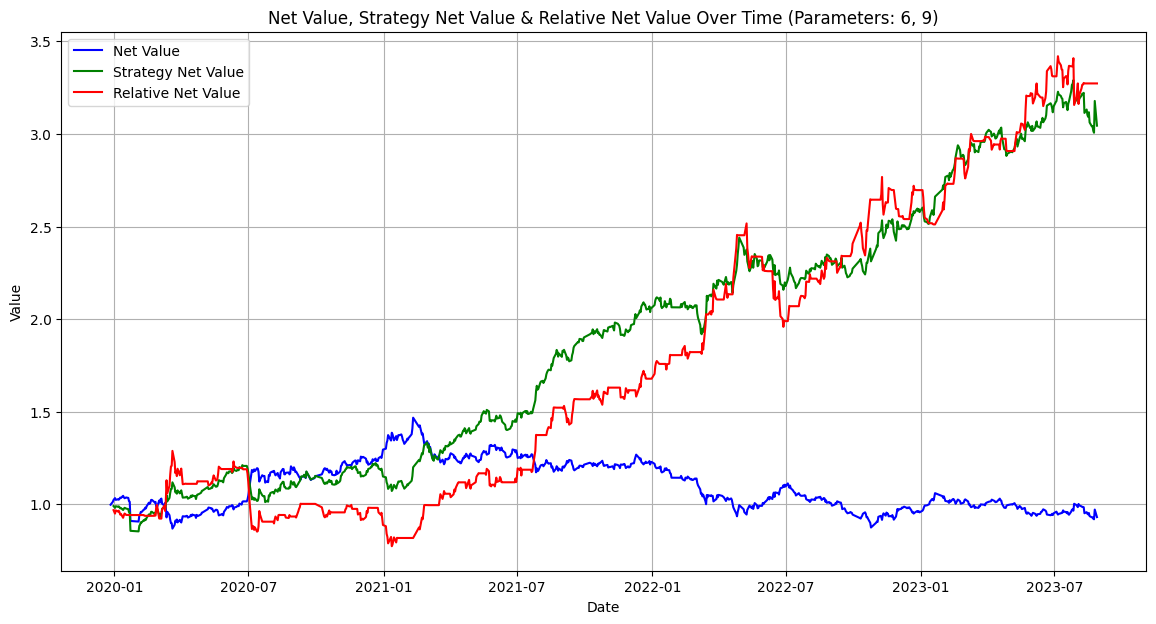

,0
相关系数,0.1128
年化收益率,0.3736
基准收益率,-0.0204
超额收益率,0.3939
夏普比率,1.6735
卡玛比率,2.2641
最大回撤,-0.1650
基准最大回撤,-0.4043
相对净值回撤,-0.4264
日胜率,0.5476


In [125]:
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['net_val'], label='Net Value', color='blue')
plt.plot(data.index, data['stg_net_val'], label='Strategy Net Value', color='green')
plt.plot(data.index, data['relative_val'], label='Relative Net Value', color='red')
plt.title('Net Value, Strategy Net Value & Relative Net Value Over Time (Parameters: 6, 9)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

stats

In [139]:
sns.lineplot(data['relative_val'], label='Relative Net Value')
plt.title('HS300, Volume PCR: Relative Net Value and Drawdown')

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'HS300, Volume PCR: Relative Net Value and Drawdown')

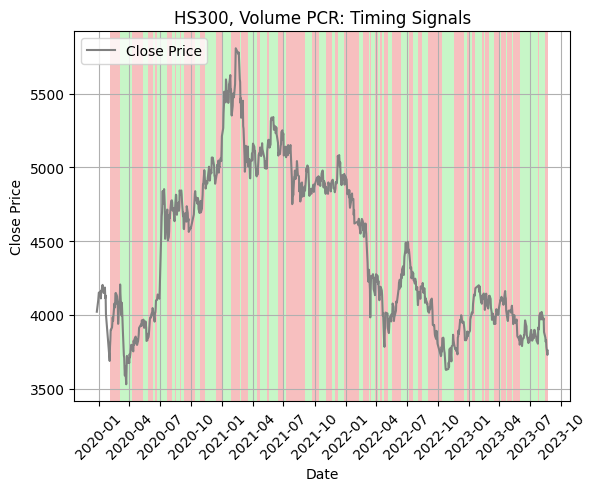

In [253]:
# 重新导入matplotlib.dates模块
import matplotlib.dates as mdates

# 择时信号图
plt.figure()
plt.plot(data.index, data['000300.SH'], label='Close Price', color='gray')

# Shade区间根据多空信号
signal_changes = np.where(data['sig'].diff().abs() > 0)[0]
signal_changes = np.append(signal_changes, len(data) - 1)

for start, end in zip(signal_changes, signal_changes[1:]):
    color = 'lightcoral' if data['sig'].iloc[start] >0 else 'lightgreen'
    plt.axvspan(data.index[end], data.index[start], facecolor=color, alpha=0.5)

plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('HS300, Volume PCR: Timing Signals')
plt.legend()
plt.grid(True)

# 设置x轴为按月标记，3个月为间隔
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)

plt.show()


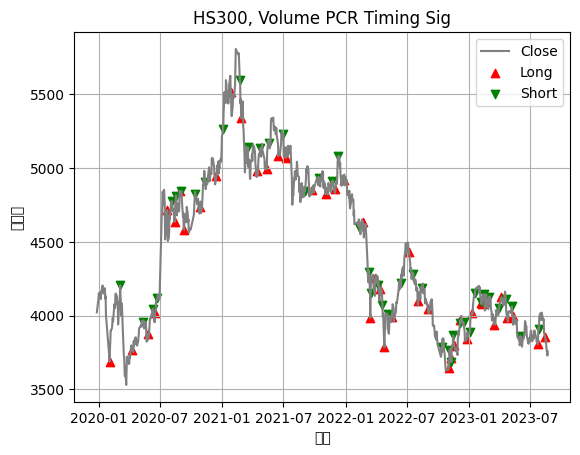

In [260]:
# 绘制择时信号图
plt.figure()
plt.plot(data.index, data['000300.SH'], label='Close', color='gray')
plt.scatter(data[data['sig_diff']>0].index, data['000300.SH'][data['sig_diff']>0], marker='^', color='r', label='Long')
plt.scatter(data[data['sig_diff']<0].index, data['000300.SH'][data['sig_diff']<0], marker='v', color='g', label='Short')
plt.xlabel('日期')
plt.ylabel('收盘价')
plt.title('HS300, Volume PCR Timing Sig')
plt.legend()
plt.grid(True)
plt.show()

Text(0.5, 1.0, 'HS300, Volume PCR')

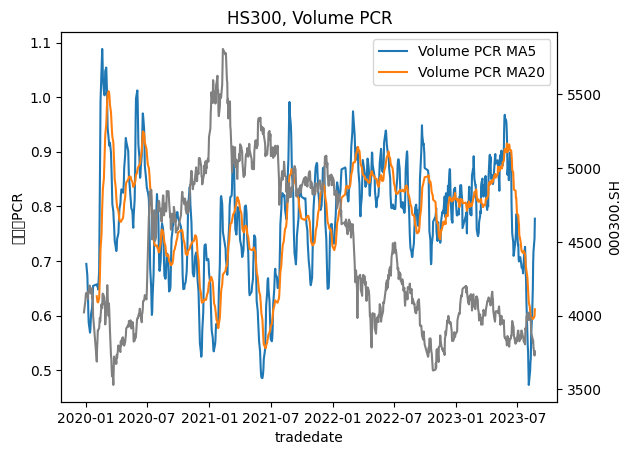

In [276]:
fig,ax = plt.subplots()
# sns.lineplot(data['成交量PCR'], label='Volume PCR',ax=ax)
sns.lineplot(data['成交量PCR'].rolling(5).mean(), label='Volume PCR MA5', ax=ax)
sns.lineplot(data['成交量PCR'].rolling(20).mean(), label='Volume PCR MA20', ax=ax)

sns.lineplot(data['000300.SH'],ax=ax.twinx(),color='grey')

plt.title('HS300, Volume PCR')

Text(0.5, 1.0, 'HS300, Volume PCR')

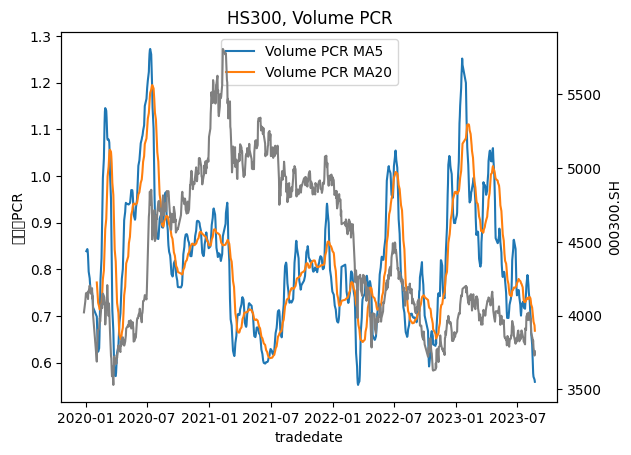

In [277]:
fig,ax = plt.subplots()
# sns.lineplot(data['成交量PCR'], label='Volume PCR',ax=ax)
sns.lineplot(data['持仓量PCR'].rolling(5).mean(), label='Volume PCR MA5', ax=ax)
sns.lineplot(data['持仓量PCR'].rolling(20).mean(), label='Volume PCR MA20', ax=ax)

sns.lineplot(data['000300.SH'],ax=ax.twinx(),color='grey')

plt.title('HS300, Volume PCR')

In [362]:

data[['000300.SH','relative_ret','sig']].iloc[-20::].iloc[::-1].to_clipboard()

## use backtrader to assure